# Border Collies vs. Australian Shepherds Image Classification

Hello, and welcome to this image classification notebook, where I will demonstrate how to do image classification using deep learning/neural networks on a custom dataset that I collected. Using about 500 collected images of two similar looking dog breeds will yield 90+% accuracy in a matter of minutes.

*Note 

### The Problem

After the death of my family's beloved 15-year old Border Collie, Archie, my mother recently looked into rescuing another. After contacting a group in the midwest who believed they were taking care of a Border Collie, my mother was shocked to find that it was actually an Australian Shepherd.

These two herding dog breeds look similar, and it can be hard to tell the difference!

![which is which?](https://dogsoulmate.de/wp-content/uploads/2018/03/img_2399-1-768x616.jpg)

### Fast.ai

I will be using the fast.ai wrapper for the PyTorch library to in this project. In the past, I may have found myself using Tensorflow (or to quickly iterate, the Keras wrapper), but recently I have become enamored with PyTorch's flexible dynamic graphs and modern architecture. Fast.ai's courses has been an invaluable resource as an introduction to PyTorch and deep learning, but their ready-made implementation modern best practices makes the library essential.

Here's a [quick comparison](https://www.fast.ai/2018/10/02/fastai-ai/) of fast.ai vs. Keras on Kaggle’s Dogs vs Cats competition.

![fastai_vs_keras](fastai_vs_keras.png "Title")

This notebook will run on Fast.ai v1.0

In [165]:
# Update and reload
%reload_ext autoreload
%autoreload 2

# Import Fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

# Import other libraries
import os
import numpy as np
import shutil 
from random import sample

%matplotlib inline

np.random.seed(33)

## The Data

To build this dataset, I collected image urls from the following Google searches: 'Australian Shepherd', 'Border Collie', 'Australian Shepherd Puppy', 'Border Collie Puppy', 'Australian Shepherd Blue', 'Border Collie Blue', 'Australian Shepherd Red', 'Border Collie Red', 'Australian Shepherd Tri-Color', 'Border Collie Tri-Color'. The following function leverages fast.ai's download_images function to download the images from url's supplied and place them into an appropriate directories.

In [166]:
def get_images(object_type, sub_type, categories):
    path = Path('data/{}'.format(object_type))
    dest = path/sub_type/'images'
    dest.mkdir(parents=True, exist_ok=True)
    files = ['{}_{}.csv'.format(sub_type, category) for category in categories]
    for file in files:
        pre = (file.split('_', 1)[1].split('.', 1)[0] + '_')
        download_images(path/sub_type/file, dest)
        [os.rename("{}/{}".format(dest, f), "{}/{}{}".format(dest, pre, f)) for f in os.listdir(dest) if '_' 
         not in f]

(The code to run this function (and use fast.ai's verify_images to check for broken links) is commented out since  the action has already been performed.)

In [167]:
object_type = 'dogs'
sub_types = ['aussie', 'border']
categories = ['simple', 'puppy', 'red', 'blue', 'tri']
# for sub_type in sub_types:
#     get_images(object_type=object_type, sub_type=sub_type, categories=categories)

path = Path('data/dogs')
classes= sub_types
# for c in classes:
#     print(c)
#     verify_images(path/c/c, delete=True, max_size=500)   

Let's examine the data. Our classes are going to be a little imbalanced, but not to such a great degree that would require techniques like SMOTE (Synthetic Minority Oversampling Technique), or undersampling the majority class. I do however, want to have the same amount of Border Collies and Aussies in my validation and test sets. A split of 60/20/20 for train/validate/test yields the following results:

In [168]:
test_sizes = []
for class_ in classes:
    num_class = len([file for file in os.listdir(os.path.join(path, class_, class_)) if file.endswith('.jpg')])
    test_size = int(np.ceil(num_class/5))
    test_sizes.append(test_size)
    print("Number of {}s in the dataset:".format(class_), num_class)
    print("Train Size (60%): ", test_size*3)
    print("Test Size (20%) :", test_size)
    print()
    
test_size = min(test_sizes)

Number of aussies in the dataset: 641
Train Size (60%):  387
Test Size (20%) : 129

Number of borders in the dataset: 545
Train Size (60%):  327
Test Size (20%) : 109



This looks good. Time to split the data.

In [169]:
def train_val_test_split(class_):
    '''
    Copies files into train, validation, and test folders'''
    # Create new train/validate/test folders
    train_dir = os.path.join(path, 'train', class_)
    test_dir = os.path.join(path, 'test', class_)
    val_dir = os.path.join(path, 'valid', class_)
    for directory in [train_dir, val_dir, test_dir]:
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)
    
    # Create a subset of indices
    files = [file for file in os.listdir(os.path.join(path, class_, class_)) if file.endswith('.jpg')]
    num_class = len([file for file in files])
    sequence = [i for i in range(num_class)]
    subset = sample(sequence, test_size*2)
    val_subset = [item for index, item in enumerate(subset) if index % 2 == 0]
    test_subset = [item for index, item in enumerate(subset) if index % 2 == 1]
    
    # Move files to directories if count in subset
    count = 0
    for file in files:
        file = os.path.join(path, class_, class_, file)
        if count in test_subset:
            shutil.copy(file, test_dir)
        elif count in val_subset:
            shutil.copy(file, val_dir)
        else:
            shutil.copy(file, train_dir)
        count += 1
    
for class_ in classes:
    train_val_test_split(class_)

Let's create an ImageDataBunch object from the images in these folders. We'll set the batch size to 32 and do various data augmentation on images in each batch. I'll set the size to 224 x 224, which is used in Resnet.

Classes: ['aussie', 'border'] 
Training Samples: 750 
Validation Samples: 218 
Testing Samples: 218


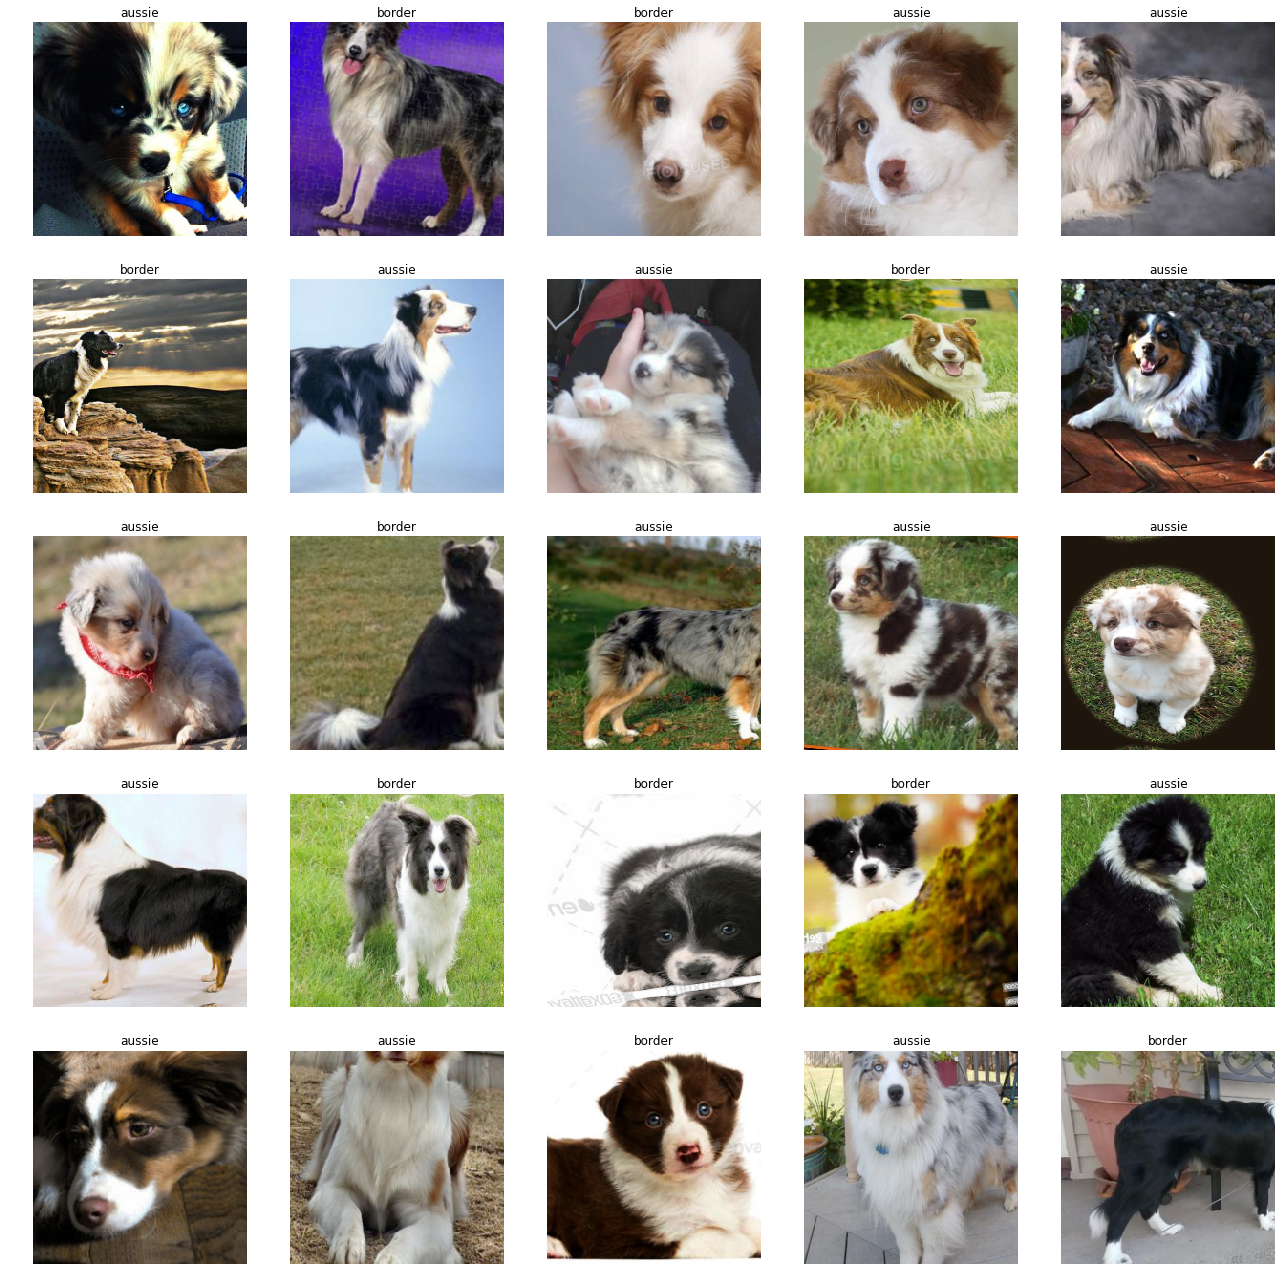

In [170]:
data = ImageDataBunch.from_folder(path, train='train', valid='valid', test='test', bs=64,
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=False, 
                                                          max_rotate=12.0, max_zoom=1.2, 
                                                          max_lighting=0.3, max_warp=0.3, 
                                                          p_affine=0.75, p_lighting=0.75), size=224, 
                                                         num_workers=4).normalize(imagenet_stats)

print("Classes:", data.classes, "\nTraining Samples:", len(data.train_ds), "\nValidation Samples:", len(data.valid_ds), 
      "\nTesting Samples:", len(data.test_ds))

data.show_batch(rows=5, figsize=(18,18))

We can see the various transformations in the arguments shown in this batch.

## Transfer learning

Time to create a convolutation neural network learner object. We'll use resnet34 as the base architecture and use transfer learning to quickly repurpose the last convolutional layer of the pre-trained model on the limited data collected for the stated task.

This following model will freeze the earlier layers and only train the head. Later, we will unfreeze the earlier layers.

This is a two-class problem, so I'll also report the accuracy.

In [171]:
path = 'data/dogs'
learn = create_cnn(data, models.resnet34, metrics=accuracy, ps=0.5)

What happened here? [According to the documentation](https://docs.fast.ai/vision.learner.html#create_cnn):

>This method creates a Learner object from the data object and model inferred from it with the backbone given in arch. Specifically, it will cut the model defined by arch (randomly initialized if pretrained is False) at the last convolutional layer by default (or as defined in cut, see below) and add:

> * an AdaptiveConcatPool2d layer
> * a Flatten layer
> * blocks of [nn.BatchNorm1d, nn.Dropout, nn.Linear, nn.ReLU] layers.

>The blocks are defined by the lin_ftrs and ps arguments. Specifically, the first block will have a number of inputs inferred from the backbone arch and the last one will have a number of outputs equal to data.c (which contains the number of classes of the data) and the intermediate blocks have a number of inputs/outputs determined by lin_frts (of course a block has a number of inputs equal to the number of outputs of the previous block). The default is to have an intermediate hidden size of 512 (which makes two blocks model_activation -> 512 -> n_classes). If you pass a float then the final dropout layer will have the value ps, and the remaining will be ps/2. If you pass a list then the values are used for dropout probabilities directly.

Here, I used the default ps value of 0.5.

Let's examine how the loss changes with different learning rates so we can determine the learning rate that will allow it to converge quickly and minimize losses.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


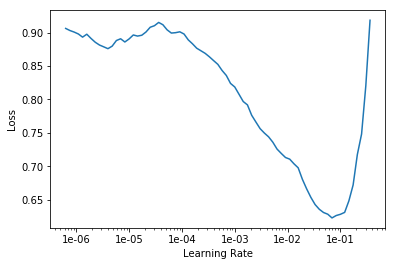

In [172]:
learn.lr_find()
learn.recorder.plot()

We can be confident the losses should be decreasing with a learning rate of 5e-03.

According to the [one-cycle-policy](https://sgugger.github.io/the-1cycle-policy.html), the fitting this model will:

> [...] do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum. The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower. Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.

> [... use] a lower value [learning rate] to warm-up the training 

>[...increase it] rather slowly go there linearly, and to take as much time going up as going down.

> Then the last part of the training, with descending learning rates up until annihilation will allow us to go inside a steeper local minimum inside that smoother part.

The reason for this is that the high learning rates will perform regularization to prevent overfitting and find a flatter mimimum for the loss function. Then by decreasing the the learning rate, we can see the significant improvements in the loss.

As the learning rate is high, the momemntum will be decreased so that the gradients will be given more weight. Then it will be decreased once again as during the learning rate decrease (according to cosine annealing).

In [173]:
learn.fit_one_cycle(5, max_lr=5e-03)

Great! It looks like in mere seconds we have a model accuracy of around 90%. That's pretty good!

Let's see what happened with the learning rate and momentum along the batches.

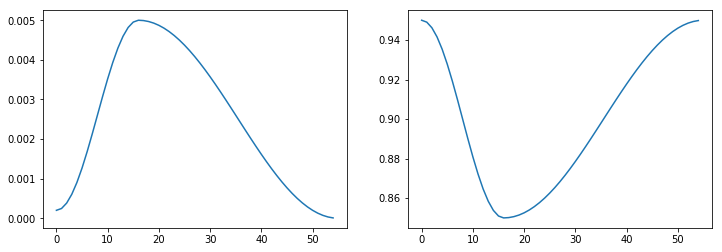

In [174]:
learn.recorder.plot_lr(show_moms=True)

We can see the learning rate rise, then cosine rate annealing. THe momentum simultanesouly decreased, following the one-cycle policy.

In [175]:
learn.save('model-1')

## Fine-Tuning

Let's unfreeze all the layers and practice fine-tuning. Here we will want to 

In [176]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


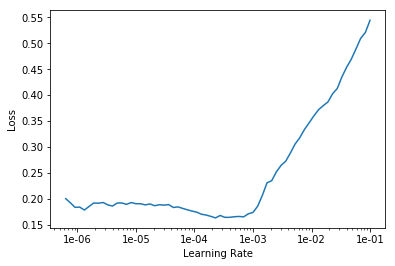

In [177]:
learn.lr_find()
learn.recorder.plot()

It looks like we can use learning rates up to about 1e-04  We'll follow a policy of differential learning rates, so use a lower learning rate on earlier layers since we don't need to improve much on basic shapes and edges, then increase it more in later layers, which are more object-oriented.

In [178]:
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-04))

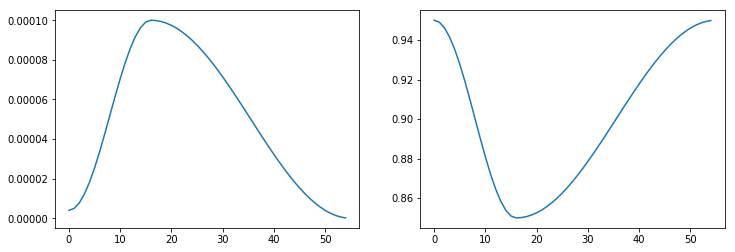

In [179]:
learn.recorder.plot_lr(show_moms=True)

In [180]:
learn.save('model-2')

In [181]:
learn.fit_one_cycle(3, max_lr=slice(1e-06, 1e-04))

In [182]:
learn.save('model-3')

It looks like our validation loss has just about stopped improving after 8 epochs. Let's look at the model.

In [183]:
learn.load('model-3')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (750 items)
[Category aussie, Category aussie, Category aussie, Category aussie, Category aussie]...
Path: data/dogs
x: ImageItemList (750 items)
[Image (3, 375, 500), Image (3, 396, 441), Image (3, 332, 500), Image (3, 375, 500), Image (3, 500, 467)]...
Path: data/dogs;

Valid: LabelList
y: CategoryList (218 items)
[Category aussie, Category aussie, Category aussie, Category aussie, Category aussie]...
Path: data/dogs
x: ImageItemList (218 items)
[Image (3, 400, 300), Image (3, 333, 500), Image (3, 425, 500), Image (3, 375, 500), Image (3, 500, 467)]...
Path: data/dogs;

Test: LabelList
y: CategoryList (218 items)
[Category aussie, Category aussie, Category aussie, Category aussie, Category aussie]...
Path: data/dogs
x: ImageItemList (218 items)
[Image (3, 466, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 360, 480), Image (3, 488, 366)]...
Path: data/dogs, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3

## Evaluation on Test Set
Even though we have been choosing model hyperperameters based on the validation set, that isn't enough. We need to use a test set to determine the validity of our model. Why? The hyperperameters can be biased to the validation set.

In [184]:
learn.validate(dl=learn.dl(ds_type='test'), metrics=[accuracy])

[0.35742214, tensor(0.8991)]

This looks in line with our validation set testing.

Let's look at the most correct predictions:

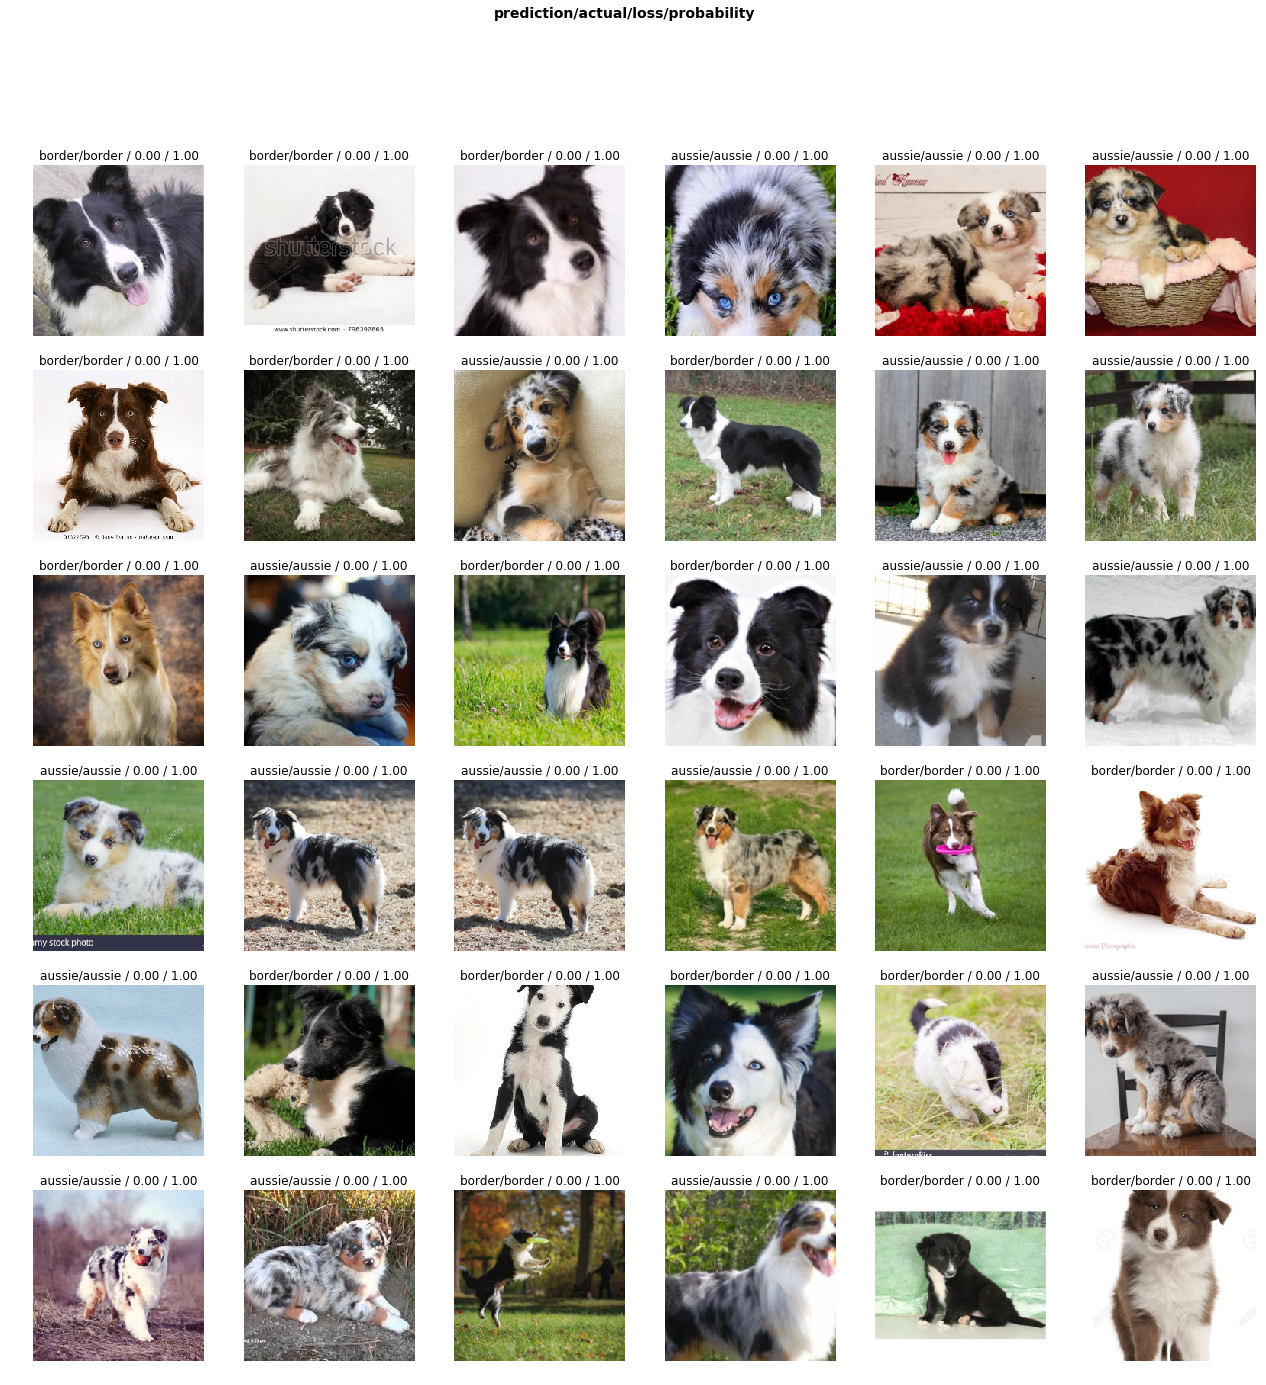

In [185]:
interp = ClassificationInterpretation.from_learner(learn, ds_type='test')
interp.plot_top_losses(6**2, figsize=(22,22), largest=False)

And now the most incorrect:

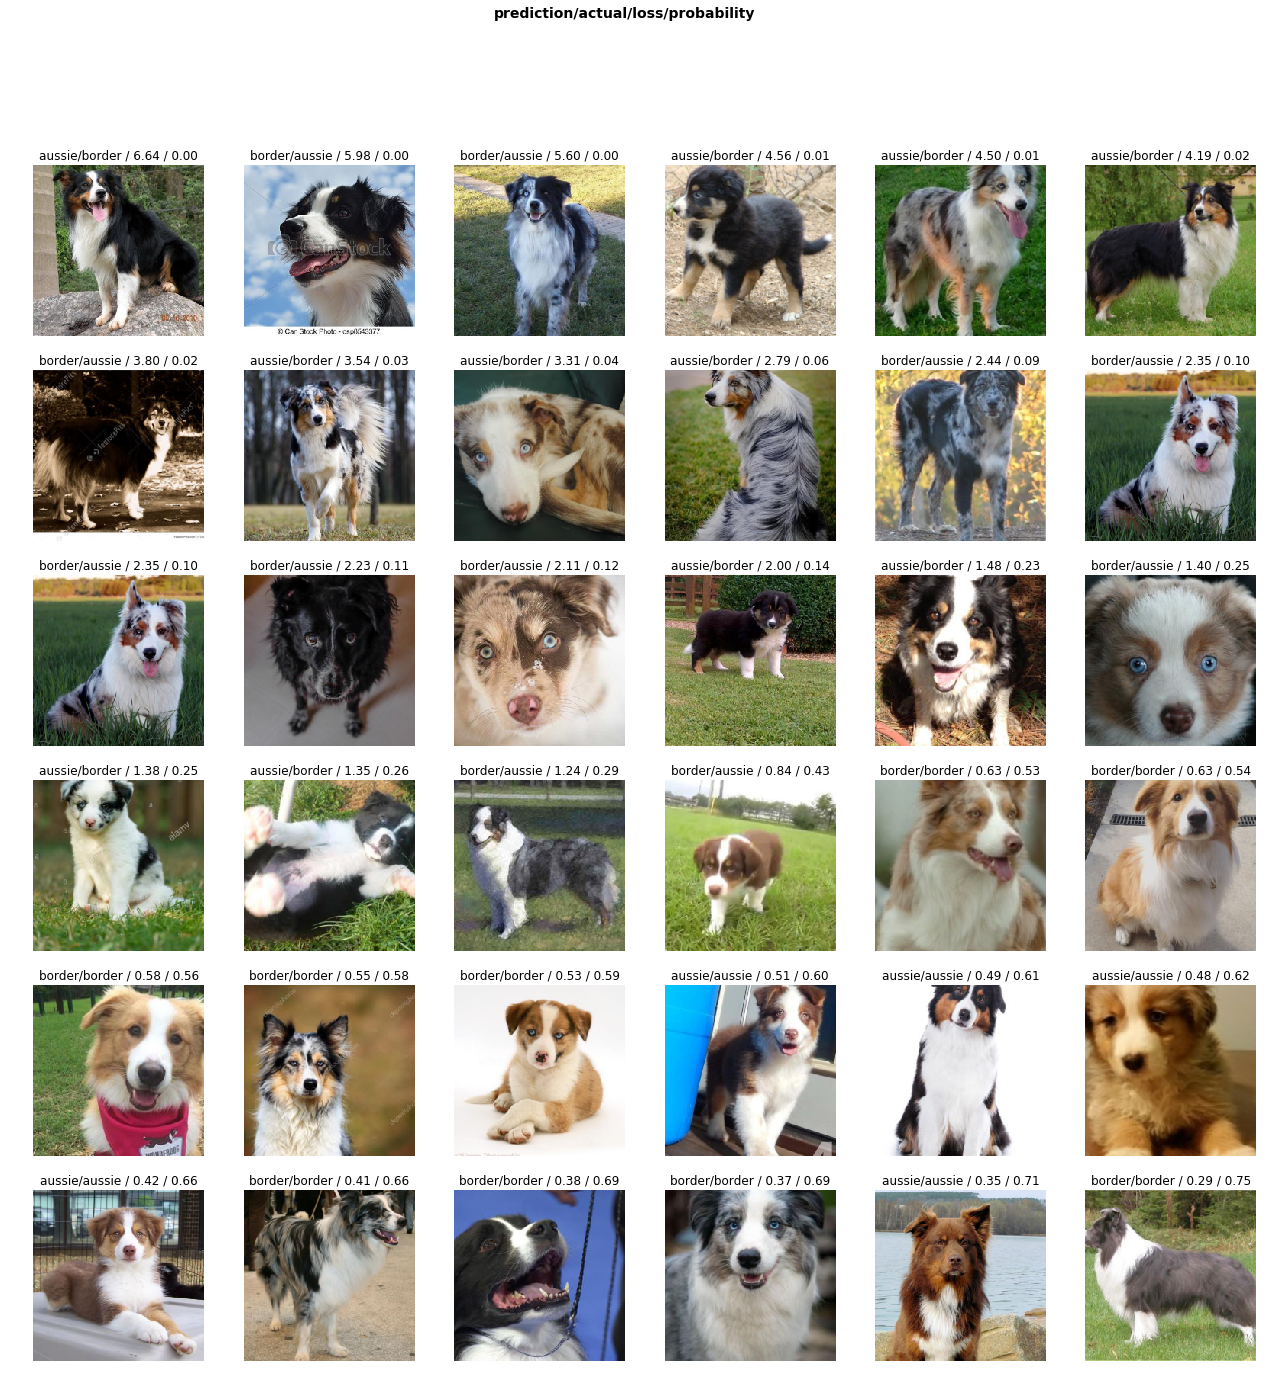

In [186]:
interp.plot_top_losses(6**2, figsize=(22, 22), largest=True)

Most of the incorrect ones are the same mistakes I would make! It may even be possible that some of these dogs have been mislabeled...

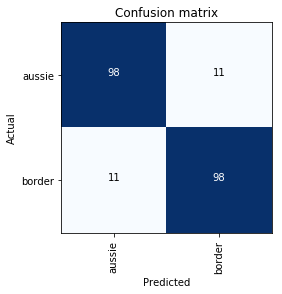

In [187]:
interp.plot_confusion_matrix()

Let's see how it can predict my dogs!

In [189]:
my_dogs = ['Tuxedo (1991-2003), pictured age 3', 'Archie (2003-2018), pictured age 14', 'Judy (2013- ), pictured age 2']

def show_dog(my_dog):
    img = open_image(path + '/predict/{}.jpg'.format(my_dog.split(' ', 1)[0].lower())).resize((1,224, 224))
    pred_class,pred_idx,outputs = learn.predict(img)
    print(my_dog)
    print("Predicted class:", pred_class, "with a probability of", int(np.round(outputs.max().item(), 2)*100), '%')
    img.show()

Tuxedo (1991-2003), pictured age 3
Predicted class: border with a probability of 99 %


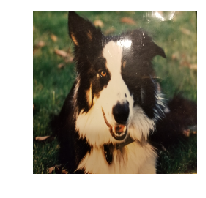

In [190]:
show_dog(my_dogs[0])

Archie (2003-2018), pictured age 14
Predicted class: border with a probability of 100 %


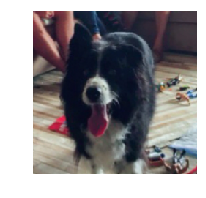

In [191]:
show_dog(my_dogs[1])

Judy (2013- ), pictured age 2
Predicted class: aussie with a probability of 97 %


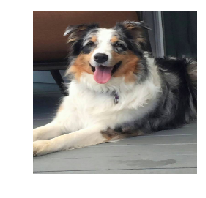

In [192]:
show_dog(my_dogs[2])

Unsurprisingly, it gets my dogs' breeds correct. They aren't borderline cases!

## Next Steps

Unfortunately for mom, her contacts did not have this image classifier, or else this problem could have been solved to 90% accuracy! But how can it be made more precise?

The most important improvement that can be made is to get more data and better data. It is trivial that having more data to train on will lead to a more accurate model. I, some of the images may have been mislabled -- there may be better sources out there.

In addition, we could try feeding the model higher resolution images (after all, the model trained in mere seconds!), experimenting with different architectures, trying different data transformations, hyper-perameters, experimenting with re-sampling, freezing and unfreezing different layers, ensembling different models, and more.

## Further Exploration

In [194]:
from fastai.callbacks.hooks import *

In [195]:
xb,_ = data.one_item(img)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
m = learn.model.eval();

In [196]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

hook_a,hook_g = hooked_backward()

In [197]:
acts  = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)
t = data.valid_ds[0][0].data;

In [200]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

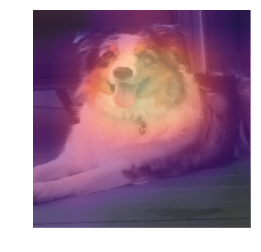

In [201]:
show_heatmap(avg_acts)